**My main objective**: finish the first project cycle deploying a solution to the CFO so he can make his decisions.

# 0.0. IMPORTS

In [26]:
import math
import pylab
import warnings
import inflection # used when renaming columns in subsection 1.1
import datetime

import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gs

from scipy import stats as ss
from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings( 'ignore' )

## Helper Functions

Here there are some functions that will be helpful in the project

In [2]:
# setting some notebook display as default
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
pd.set_option( 'display.float_format', lambda x: '%.2f' % x )

# setting plot parameters as default
plt.rcParams[ 'figure.figsize' ] = [25, 12]
plt.rcParams[ 'font.size' ] = 24
sns.set_style( "white" )

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory = False) # other store features

# merging datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. STEP 1: DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

We basically rename them to better manipulate and visualize the data, since the names become shortly and intuitive after renaming

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# creating new names with a snakecase pattern
snakecase = lambda x: inflection.underscore( x )

# creating a list containing the new column names
cols_new = list(map(snakecase, cols_old))

# renaming the dataframe columns
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] ) # changing 'date' column from object to pandas datetime
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking for NANs

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Filling out NANs

**competition_distance:**

I'll assume that if the value is missing it's because there'no competitor close to the store. Thus if I input a distance greater than the maximum distance of the column it's the same as there'no competitor close.

The maximum distance is 75.860m. So, if the value is missing, I will input 200.000m

In [8]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

**competition_open_since_month** and **competition_open_since_year:**

There can be two reasons for missing values in this column:
- the store doesn't really have a close competitor.
- The store does have a close competitor, but we don't know when it was opened. Maybe the competitor existed before or after the store opening.

So, what I'll do: if the store has a NA in this column, I'll copy the date from this line to the competition_since_month. The main reason to do it is because I believe that this column is important to the model.

For now, it's not a big problem because I'm working in cycles. Thus, if this assumption doesn't help in the modeling performance, I handle it in the next CRISP cycle.

In [9]:
# competition_open_since_month
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace=True )

In [10]:
# competition_open_since_year
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace=True )

**promo2_since_week** and **promo2_since_year**:

If there are missing values in these columns, it's because the store is not participating in promo2.
So, we'll fill it out with the present date.

In [11]:
df1['promo2_since_week'].fillna( df1['date'].dt.isocalendar().week, inplace=True )
df1['promo2_since_year'].fillna( df1['date'].dt.year, inplace=True )

**promo_interval**:

In [12]:
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna('', inplace=True) 

# getting month abreviation
df1['month_map'] = df1['date'].dt.strftime( "%b" ) 

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

## 1.6. Change Data Types

Some features has float as type but they should be integer. So, they're going to be changed.

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

This subsection provides both a business notion (with metrics of dispersion and central tendency) and a detection of error in the data

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int32
dtype: object

In [15]:
# dividing data in numerical and categorical
num_attributes = df1.select_dtypes( include = ['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [16]:
# Central Tendendy - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skewness, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame(num_attributes.quantile( .25 )).T
d5 = pd.DataFrame(num_attributes.quantile( .75 )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# concatenating them and printing
m = pd.concat( [d2, d3, d6, d4,  ct2, d5, ct1, d1, d7, d8] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', '25%','median','75%', 'mean', 'std', 'skewness', 'kurtosis'] # renaming columns
m

,attributes,min,max,range,25%,median,75%,mean,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,280.0,558.0,838.0,558.429727,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,2.0,4.0,6.0,3.998341,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,3727.0,5744.0,7856.0,5773.818972,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,405.0,609.0,837.0,633.145946,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,1.0,1.0,1.0,0.830107,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.0,0.0,1.0,0.381515,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.0,0.0,0.0,0.178647,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,710.0,2330.0,6910.0,5935.442677,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,4.0,7.0,10.0,6.786849,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2008.0,2012.0,2014.0,2010.324840,5.515591,-7.235657,124.071304


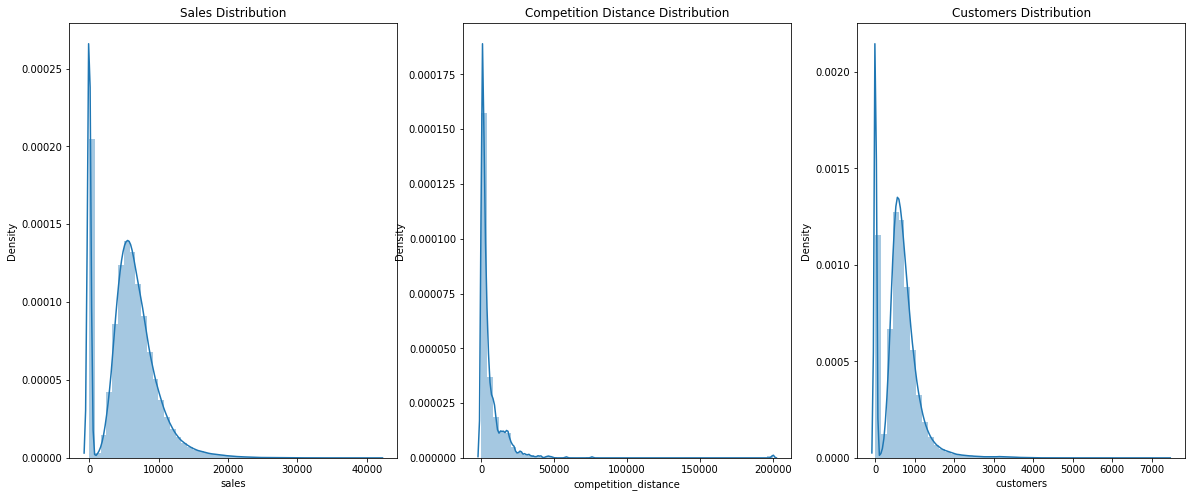

In [53]:
plt.figure(figsize=(20, 8))

plt.subplot( 1,3,1)
sns.distplot( df1['sales'] )
plt.title( 'Sales Distribution' )

plt.subplot( 1,3,2 )
sns.distplot( df1['competition_distance'] )
plt.title( 'Competition Distance Distribution' );

plt.subplot( 1,3,3 )
sns.distplot( df1['customers'] )
plt.title( 'Customers Distribution' );

In EDA Section I'll check if sales distribution is or not normal.

### 1.7.1. Categorical Attributes

In [54]:
# taking a first look at the levels of each categorical variables
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

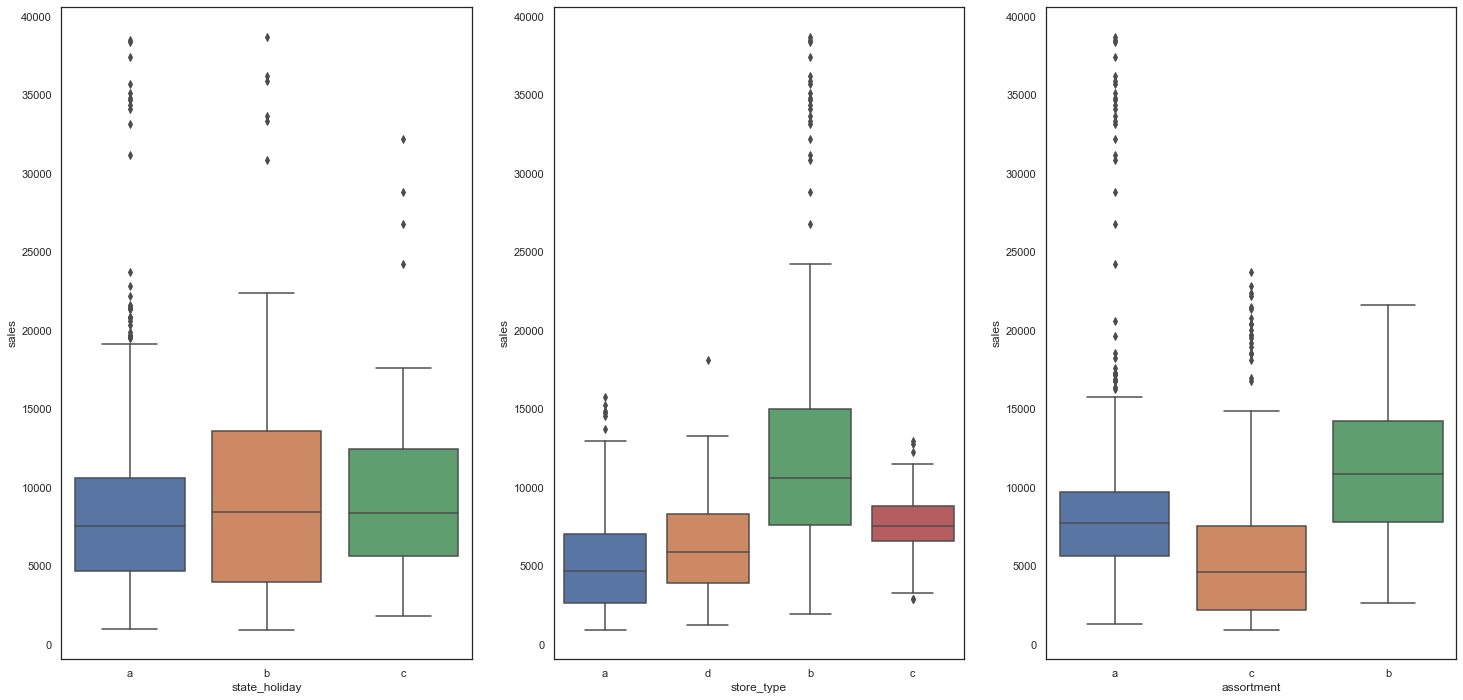

In [62]:
aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y ='sales', data = aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y ='sales', data = aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux );

# 2.0. STEP 2: FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

To better understand the relationship between the target variable (sales) and the features, I'll create some hypothesis based on the business problem to guide the feature engineering and then the exploratory data analysis.

In the EDA section, I'll validate these hypothesis and it'll let me have a good notion about the relation between the features and the target and it will help me to choose more accurately what feature to use when modeling.

However, before I do that, a mind map can be useful when creating all the hypothesis.

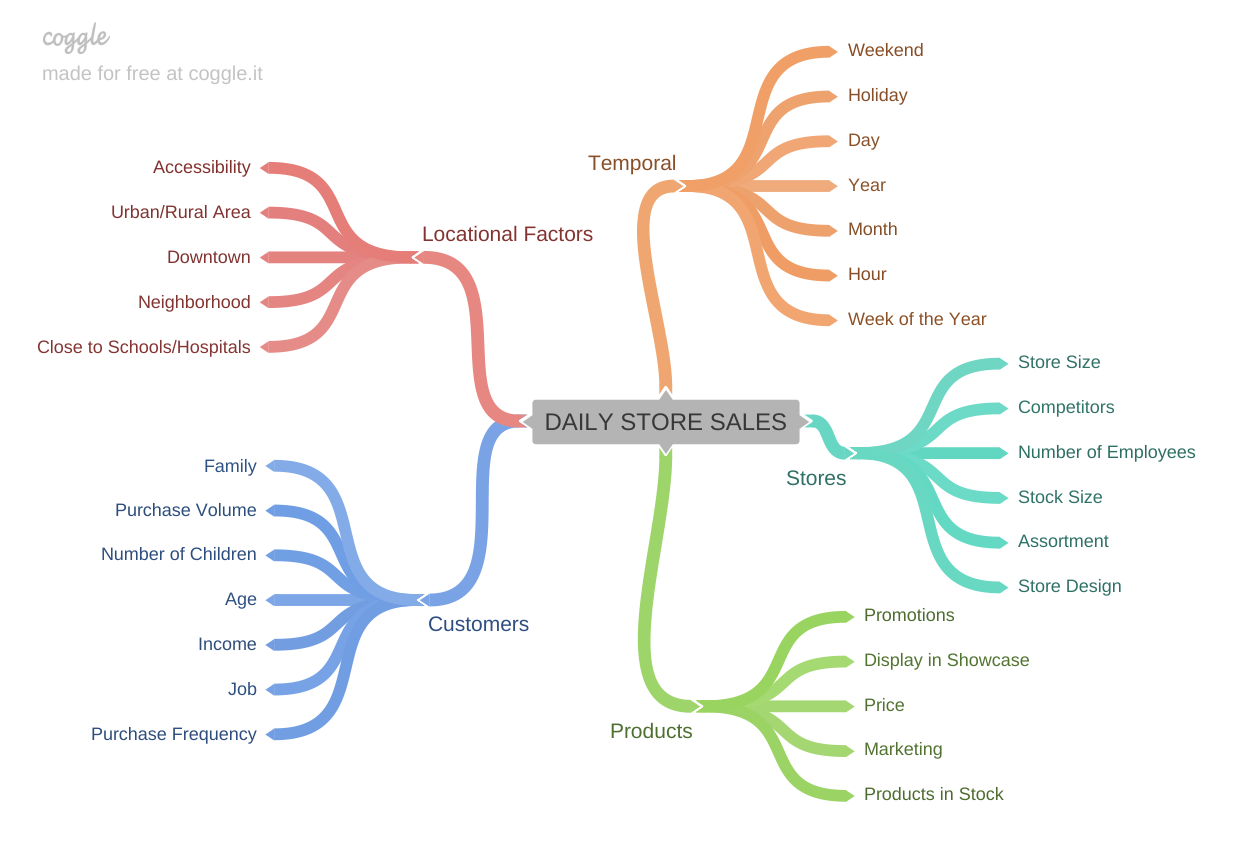

In [17]:
Image( '../img/HypMindMap.png' )

## 2.2. Hypothesis Creaiton

### 2.1.1. Store Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more

### 2.1.1. Product Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.1.1. Temporal Hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should be selling more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3. Hypothesis Final List

The next step is to choose which of them will be considered in the EDA section. The criterion I'll use is the availability of the corresponding feature. For instance, there's no data for number of employees or stock size, so, their corresponding hypothesis will not be considered.

This, the following hypothesis final list is created.

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should be selling more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4. Feature Engineering

Now it's time to create some new features. It'll basically follow the needs of the list of hypothesis.

**Year, month, day, week of year and year week**

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

**competition since** and **promo since**

There are two columns related to competition. I'll make them only one date and then subract from the sale's date. It's the basically the same for promo since

In [28]:
# competition_since: how long the competition exists considering the purchase date
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis = 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int ) # to get month

In [29]:
# promo_since: how long is there an active promotion
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

**assortment** and **state holiday**

In [30]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

Since store type has no description in the data source, I wont change it.

# 3.0. STEP 3: FILTERING VARIABLES

In [35]:
df3 = df2.copy()

Based on business restrictions (e.g. we won't have a variable avaliable in the future to use in the prediciton), we have to properly filter variables.

## 3.1. Row Filtering

**open:** it's kind of obvious that closed stores has no sales in that day. Thus, this column also won't be used.

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

**customers:** I can't use customers because I won't have this data for the next six weeks (the prediction period) unless I build another project to predict how many customers the stores will have in that period. Since this is not the case, I'll drop it.

**promo_interval** and **month_map** were used to create new columns. They'll not be used anymore.

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )